# CSGO Match Prediction with Logistic Regression

In [1]:
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import pandas as pd
from sklearn import datasets, linear_model
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
%matplotlib inline

## Loading Data

In [2]:
df = pd.read_csv('./economy.csv', low_memory=False)

In [3]:
winners = df.T.apply(pd.Series.last_valid_index) # Get winner of the match

In [4]:
winners_col = [] # Creation of the winners column for the dataset
winnerarr = np.array(winners)
for i in range(df.shape[0]):
    winners_col.append(df[winnerarr[i]][i])
    #winners_col.append(df["team_" + str(int(df[winnerarr[i]][i]))][i])

In [5]:
df['match_winner'] = winners_col

In [6]:
round_win_col_names = [ # Rounds we are not parsing, we only care about rounds until halftime
 '16_winner',
 '17_winner',
 '18_winner',
 '19_winner',
 '20_winner',
 '21_winner',
 '22_winner',
 '23_winner',
 '24_winner',
 '25_winner',
 '26_winner',
 '27_winner',
 '28_winner',
 '29_winner',
 '30_winner']

df = df.drop(columns=round_win_col_names)
df = df.drop(columns=["best_of", "date", "t2_start"])
df = df.drop(columns=["match_id", "event_id"])

droprounds = ['16_t1', '17_t1', '18_t1', '19_t1', '20_t1', '21_t1', '22_t1', '23_t1', '24_t1', '25_t1', '26_t1', '27_t1', '28_t1', '29_t1', '30_t1', '16_t2', '17_t2', '18_t2', '19_t2', '20_t2', '21_t2', '22_t2', '23_t2', '24_t2', '25_t2', '26_t2', '27_t2', '28_t2', '29_t2', '30_t2']
df = df.drop(columns=droprounds)

In [7]:
colnames = list(df.columns)

In [8]:
#print(colnames)
xnames = colnames[:len(colnames) - 1]
#print(xnames)
X = df[xnames]

set_of_teams = set(list(X['team_1']) + list(X['team_2']))
team_to_num = dict(zip(set_of_teams, range(len(set_of_teams))))

#Replace team's name with their number
X['team_1'] = X['team_1'].replace(team_to_num)
X['team_2'] = X['team_2'].replace(team_to_num)
y = df["match_winner"]

#Convert from t1_start to t1_t and convert from t,ct to binary
X['t1_t'] = X['t1_start'].apply(lambda x: 1 if x == 't' else 0)
X = X.drop('t1_start', axis=1)

#Replace map names with numbers
map_to_num = dict(zip(X['_map'].unique(), range(len(X['_map'].unique()))))
X['_map'] = X['_map'].replace(map_to_num)

X

<ipython-input-8-072520d650ff>:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X['team_1'] = X['team_1'].replace(team_to_num)
<ipython-input-8-072520d650ff>:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X['team_2'] = X['team_2'].replace(team_to_num)


,team_1,team_2,_map,1_t1,2_t1,3_t1,4_t1,5_t1,6_t1,7_t1,...,7_winner,8_winner,9_winner,10_winner,11_winner,12_winner,13_winner,14_winner,15_winner,t1_t
0,2533,571,0,4350.0,1100.0,22100.0,9350.0,25750.0,10400.0,24600.0,...,2.0,2.0,1.0,2.0,2.0,2.0,2.0,2.0,2.0,1
1,2533,571,1,3900.0,7400.0,23250.0,28500.0,31900.0,31700.0,18950.0,...,2.0,1.0,1.0,2.0,2.0,2.0,2.0,2.0,2.0,0
2,2533,571,2,4150.0,14300.0,2000.0,24800.0,9000.0,23150.0,21850.0,...,1.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,1
3,571,236,1,4150.0,18050.0,21000.0,25850.0,25000.0,25000.0,27250.0,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1
4,571,236,0,4200.0,10000.0,22000.0,24500.0,27550.0,29350.0,31950.0,...,2.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
43229,2534,2755,9,4250.0,7400.0,17200.0,18500.0,26750.0,27450.0,26950.0,...,2.0,1.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,1
43230,236,2873,4,4250.0,1600.0,24250.0,17400.0,22050.0,6600.0,25650.0,...,1.0,1.0,1.0,1.0,1.0,1.0,2.0,2.0,2.0,1
43231,2169,1072,2,4350.0,7650.0,20000.0,21500.0,29150.0,26900.0,8750.0,...,2.0,2.0,2.0,1.0,1.0,2.0,2.0,1.0,1.0,0
43232,1705,1065,2,4150.0,11800.0,1200.0,22950.0,25750.0,26850.0,27850.0,...,1.0,1.0,2.0,1.0,1.0,1.0,1.0,1.0,1.0,1


In [9]:
y

0        2.0
1        2.0
2        2.0
3        1.0
4        1.0
        ... 
43229    2.0
43230    1.0
43231    1.0
43232    1.0
43233    1.0
Name: match_winner, Length: 43234, dtype: float64

***

## One-Hot Conversion (Encoding Teams)

In [10]:
# # Convert the team names back into strings again
# import gc
# num_to_team = dict(zip(range(len(set_of_teams)), set_of_teams))
# all_teams = [num_to_team[i] for i in range(len(set_of_teams))]

# # Extract the team data from the original DataFrame
# team_1_arr = np.array(X["team_1"])
# team_2_arr = np.array(X["team_2"])

# # Create the one-hot vectors for each row of the data, one for each team
# one_hot_t1 = np.zeros((team_1_arr.size, len(num_to_team)))
# one_hot_t1[np.arange(team_1_arr.size), team_1_arr] = 1

# one_hot_t2 = np.zeros((team_2_arr.size, len(num_to_team)))
# one_hot_t2[np.arange(team_2_arr.size), team_2_arr] = 1

# # Combine the matrix of one-hot vectors for team_1 and team_2 together to create a single matrix
# one_hot = np.hstack((one_hot_t1, one_hot_t2))

# # Turn the numpy array into a pandas DataFrame and add it to the dataset
# one_hot_df = pd.DataFrame(one_hot, columns = ["team_1_%s" %(i) for i in all_teams] + ["team_2_%s" %(i) for i in all_teams])
# X = X.drop(columns = ["team_1", "team_2"])
# X = X.join(one_hot_df)
# # Freeing memory for training and test dataset splits
# del team_1_arr
# del team_2_arr
# del num_to_team
# del all_teams 
# del one_hot_t1
# del one_hot_t2
# del one_hot
# del one_hot_df

# gc.collect()

***

In [11]:
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=0)

scaler = StandardScaler()
X_train= scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

## LogReg w/ No Regularization

In [12]:
logreg_ridge_none = linear_model.LogisticRegression(penalty='none') # No regularization

In [13]:
logreg_ridge_none.fit(X_train, y_train)

LogisticRegression(penalty='none')

In [14]:
yhat_train = logreg_ridge_none.predict(X_train)
yhat = logreg_ridge_none.predict(X_test)# the predict method will return 0 or 1
acc = np.mean(yhat == y_test)
acc_train = np.mean(yhat_train == y_train)
print("Accuracy on training data = %f" % acc_train)
print("Accuracy on test data = %f" % acc)

Accuracy on training data = 0.775050
Accuracy on test data = 0.776668


In [15]:
print("The regularization parameter:", logreg_ridge_none.C)
print('Accuracy on the test data is {0:f}'.format(acc))
W_l1 = logreg_ridge_none.coef_


data = {'feature': xnames, 'slope': np.squeeze(W_l1)}
dfslope = pd.DataFrame(data=data)
dfslope

The regularization parameter: 1.0
Accuracy on the test data is 0.776668


,feature,slope
0,team_1,0.001003
1,team_2,-0.000882
2,_map,-0.008742
3,t1_start,0.029645
4,1_t1,-0.050898
5,2_t1,-0.029815
6,3_t1,-0.047879
7,4_t1,0.005702
8,5_t1,0.002683
9,6_t1,0.021732


In [16]:
# For the test data we can see the number of tpr, fpr, fnr, and tnr in the confusion matrix
from sklearn.metrics import confusion_matrix
confusion_matrix(yhat, y_test)

array([[4597, 1219],
       [1195, 3798]], dtype=int64)

In [17]:
from sklearn.datasets import make_classification
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score
cv = KFold(n_splits=10, random_state=1, shuffle=True)
scores = cross_val_score(logreg_ridge_none, X, y, scoring='accuracy', cv=cv, n_jobs=-1)
print('Accuracy: %.3f (%.3f)' % (np.mean(scores), np.std(scores)))

Accuracy: 0.750 (0.007)


In [18]:
from sklearn.metrics import precision_recall_fscore_support
# Find Precision, recall and fscore using precision_recall_fscore_support nethod of sklearn
# Using y_train and y_hat_logreg
prec,recal,fscore,_= precision_recall_fscore_support(y_test,yhat,average='binary')
print('prec: ', prec)
print('recal: ', recal)
print('fscore: ', fscore)

prec:  0.7904057771664375
recal:  0.7936809392265194
fscore:  0.792039972432805


## L1 Regularization

In [19]:
logreg_ridge_l1 = linear_model.LogisticRegression(solver='liblinear', penalty='l1',warm_start=True, C = 0.001) # L1 regularization

In [20]:
logreg_ridge_l1.fit(X_train, y_train)

LogisticRegression(C=0.001, penalty='l1', solver='liblinear', warm_start=True)

In [21]:
yhat_l1 = logreg_ridge_l1.predict(X_test) # the predict method will return 0 or 1
acc = np.mean(yhat_l1 == y_test)
print("Accuracy on test data = %f" % acc)

Accuracy on test data = 0.776945


In [22]:
print("The regularization parameter:", logreg_ridge_l1.C)
print('Accuracy on the test data is {0:f}'.format(acc))
W_l1 = logreg_ridge_l1.coef_


data = {'feature': xnames, 'slope': np.squeeze(W_l1)}
dfslope = pd.DataFrame(data=data)
dfslope

The regularization parameter: 0.001
Accuracy on the test data is 0.776945


,feature,slope
0,team_1,0.000000
1,team_2,0.000000
2,_map,0.000000
3,t1_start,0.000000
4,1_t1,0.000000
5,2_t1,0.000000
6,3_t1,0.000000
7,4_t1,0.000000
8,5_t1,0.000000
9,6_t1,0.000000


In [23]:
# For the test data we can see the number of tpr, fpr, fnr, and tnr in the confusion matrix
from sklearn.metrics import confusion_matrix
confusion_matrix(yhat_l1, y_test)

array([[4513, 1132],
       [1279, 3885]], dtype=int64)

In [24]:
from sklearn.datasets import make_classification
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score
cv = KFold(n_splits=10, random_state=1, shuffle=True)
scores = cross_val_score(logreg_ridge_l1, X, y, scoring='accuracy', cv=cv, n_jobs=-1)
print('Accuracy: %.3f (%.3f)' % (np.mean(scores), np.std(scores)))

Accuracy: 0.753 (0.008)


In [25]:
from sklearn.metrics import precision_recall_fscore_support
# Find Precision, recall and fscore using precision_recall_fscore_support nethod of sklearn
# Using y_train and y_hat_logreg
prec,recal,fscore,_= precision_recall_fscore_support(y_test,yhat_l1,average='binary')
print('prec: ', prec)
print('recal: ', recal)
print('fscore: ', fscore)

prec:  0.7994685562444641
recal:  0.7791781767955801
fscore:  0.789192970184489


## L2 Regularization

In [26]:
logreg_ridge_l2 = linear_model.LogisticRegression(penalty='l2', C = 0.001) # L2 regularization

In [27]:
logreg_ridge_l2.fit(X_train, y_train)

LogisticRegression(C=0.001)

In [28]:
yhat_l2 = logreg_ridge_l2.predict(X_test) # the predict method will return 0 or 1
acc = np.mean(yhat_l2 == y_test)
print("Accuracy on test data = %f" % acc)

Accuracy on test data = 0.774725


In [29]:
print("The regularization parameter:", logreg_ridge_l2.C)
print('Accuracy on the test data is {0:f}'.format(acc))
W_l1 = logreg_ridge_l2.coef_


data = {'feature': xnames, 'slope': np.squeeze(W_l1)}
dfslope = pd.DataFrame(data=data)
dfslope

The regularization parameter: 0.001
Accuracy on the test data is 0.774725


,feature,slope
0,team_1,0.000238
1,team_2,-0.000570
2,_map,-0.005335
3,t1_start,0.026863
4,1_t1,-0.096945
5,2_t1,-0.071344
6,3_t1,-0.061719
7,4_t1,-0.035099
8,5_t1,-0.042614
9,6_t1,-0.025117


In [30]:
# For the test data we can see the number of tpr, fpr, fnr, and tnr in the confusion matrix
from sklearn.metrics import confusion_matrix
confusion_matrix(yhat_l2, y_test)

array([[4645, 1288],
       [1147, 3729]], dtype=int64)

In [31]:
from sklearn.datasets import make_classification
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score
cv = KFold(n_splits=10, random_state=1, shuffle=True)
scores = cross_val_score(logreg_ridge_l2, X, y, scoring='accuracy', cv=cv, n_jobs=-1)
print('Accuracy: %.3f (%.3f)' % (np.mean(scores), np.std(scores)))

Accuracy: 0.750 (0.007)


In [32]:
from sklearn.metrics import precision_recall_fscore_support
# Find Precision, recall and fscore using precision_recall_fscore_support nethod of sklearn
# Using y_train and y_hat_logreg
prec,recal,fscore,_= precision_recall_fscore_support(y_test,yhat_l2,average='binary')
print('prec: ', prec)
print('recal: ', recal)
print('fscore: ', fscore)

prec:  0.7829091521995618
recal:  0.8019682320441989
fscore:  0.7923240938166312


***

## Polynomial Transformation Fit

In [33]:
# Import useful polynomial library
import numpy.polynomial.polynomial as poly

## Loading Data

In [34]:
df = pd.read_csv('./economy.csv', low_memory=False)

In [35]:
winners = df.T.apply(pd.Series.last_valid_index)

In [36]:
winners_col = []
winnerarr = np.array(winners)
for i in range(df.shape[0]):
    winners_col.append(df[winnerarr[i]][i])
    #winners_col.append(df["team_" + str(int(df[winnerarr[i]][i]))][i])

In [37]:
df['match_winner'] = winners_col

In [38]:
round_win_col_names = [
 '16_winner',
 '17_winner',
 '18_winner',
 '19_winner',
 '20_winner',
 '21_winner',
 '22_winner',
 '23_winner',
 '24_winner',
 '25_winner',
 '26_winner',
 '27_winner',
 '28_winner',
 '29_winner',
 '30_winner']

df = df.drop(columns=round_win_col_names)
df = df.drop(columns=["best_of", "date", "t2_start"])
df = df.drop(columns=["match_id", "event_id"])

droprounds = ['16_t1', '17_t1', '18_t1', '19_t1', '20_t1', '21_t1', '22_t1', '23_t1', '24_t1', '25_t1', '26_t1', '27_t1', '28_t1', '29_t1', '30_t1', '16_t2', '17_t2', '18_t2', '19_t2', '20_t2', '21_t2', '22_t2', '23_t2', '24_t2', '25_t2', '26_t2', '27_t2', '28_t2', '29_t2', '30_t2']
df = df.drop(columns=droprounds)
df = df.sample(frac = .55)

In [39]:
colnames = list(df.columns)

In [40]:
#print(colnames)
xnames = colnames[:len(colnames) - 1]
#print(xnames)
X = df[xnames]

set_of_teams = set(list(X['team_1']) + list(X['team_2']))
team_to_num = dict(zip(set_of_teams, range(len(set_of_teams))))

#Replace team's name with their number
X['team_1'] = X['team_1'].replace(team_to_num)
X['team_2'] = X['team_2'].replace(team_to_num)
y = df["match_winner"]

#Convert from t1_start to t1_t and convert from t,ct to binary
X['t1_t'] = X['t1_start'].apply(lambda x: 1 if x == 't' else 0)
X = X.drop('t1_start', axis=1)

#Replace map names with numbers
map_to_num = dict(zip(X['_map'].unique(), range(len(X['_map'].unique()))))
X['_map'] = X['_map'].replace(map_to_num)

<ipython-input-40-9df4de8fea1f>:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X['team_1'] = X['team_1'].replace(team_to_num)
<ipython-input-40-9df4de8fea1f>:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X['team_2'] = X['team_2'].replace(team_to_num)


In [41]:
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=0)

scaler = StandardScaler()
X_train= scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

Fit Deg:  1
Predict Deg:  1
Training Set Results
[[7760 1940]
 [2051 6083]]
              precision    recall  f1-score   support

         1.0       0.79      0.80      0.80      9700
         2.0       0.76      0.75      0.75      8134

    accuracy                           0.78     17834
   macro avg       0.77      0.77      0.77     17834
weighted avg       0.78      0.78      0.78     17834

[[2603  635]
 [ 702 2005]]
              precision    recall  f1-score   support

         1.0       0.79      0.80      0.80      3238
         2.0       0.76      0.74      0.75      2707

    accuracy                           0.78      5945
   macro avg       0.77      0.77      0.77      5945
weighted avg       0.77      0.78      0.77      5945



c:\users\justin\appdata\local\programs\python\python39\lib\site-packages\sklearn\linear_model\_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Fit Deg:  2
Predict Deg:  2
Training Set Results
[[7997 1703]
 [1868 6266]]
              precision    recall  f1-score   support

         1.0       0.81      0.82      0.82      9700
         2.0       0.79      0.77      0.78      8134

    accuracy                           0.80     17834
   macro avg       0.80      0.80      0.80     17834
weighted avg       0.80      0.80      0.80     17834

[[2561  677]
 [ 740 1967]]
              precision    recall  f1-score   support

         1.0       0.78      0.79      0.78      3238
         2.0       0.74      0.73      0.74      2707

    accuracy                           0.76      5945
   macro avg       0.76      0.76      0.76      5945
weighted avg       0.76      0.76      0.76      5945



c:\users\justin\appdata\local\programs\python\python39\lib\site-packages\sklearn\linear_model\_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Fit Deg:  3
Predict Deg:  3
Training Set Results
[[9690   10]
 [  13 8121]]
              precision    recall  f1-score   support

         1.0       1.00      1.00      1.00      9700
         2.0       1.00      1.00      1.00      8134

    accuracy                           1.00     17834
   macro avg       1.00      1.00      1.00     17834
weighted avg       1.00      1.00      1.00     17834

[[2345  893]
 [ 907 1800]]
              precision    recall  f1-score   support

         1.0       0.72      0.72      0.72      3238
         2.0       0.67      0.66      0.67      2707

    accuracy                           0.70      5945
   macro avg       0.69      0.69      0.69      5945
weighted avg       0.70      0.70      0.70      5945

Best degree 1 with RMSE 0.4742308189461663


Text(0, 0.5, 'RMSE')

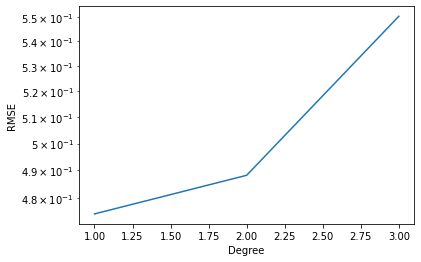

In [46]:
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import PolynomialFeatures
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report

import gc
rmses = []
degrees = [1, 2, 3]
min_rmse, min_deg = 1e10, 0

for deg in degrees:

    # Train features
    poly_features = PolynomialFeatures(degree=deg, include_bias=False)
    x_poly_train = poly_features.fit_transform(X_train)

    # Logistic regression
    poly_reg = linear_model.LogisticRegression(penalty='l2', C = 0.01)
    poly_reg.fit(x_poly_train, y_train)

    # Compare with test data
    x_poly_test = poly_features.fit_transform(X_test)
    print("Fit Deg: ", deg)
    predict_train = poly_reg.predict(x_poly_train)
    predict_test = poly_reg.predict(x_poly_test)
    print("Predict Deg: ", deg)
    poly_mse = mean_squared_error(y_test, predict_test)
    poly_rmse = np.sqrt(poly_mse)
    rmses.append(poly_rmse)
    
    
    print("Training Set Results")
    print(confusion_matrix(y_train,predict_train))
    print(classification_report(y_train,predict_train))
    print(confusion_matrix(y_test,predict_test))
    print(classification_report(y_test,predict_test))
    # Cross-validation of degree
    if min_rmse > poly_rmse:
        min_rmse = poly_rmse
        min_deg = deg
    
    del poly_features
    del x_poly_train
    del poly_reg
    del x_poly_test
    del predict_test
    del predict_train
    gc.collect()

# Plot and present results
print('Best degree {} with RMSE {}'.format(min_deg, min_rmse))
        
fig = plt.figure()
ax = fig.add_subplot(111)
ax.plot(degrees, rmses)
ax.set_yscale('log')
ax.set_xlabel('Degree')
ax.set_ylabel('RMSE')

In [ ]:
# from sklearn.preprocessing import PolynomialFeatures
# # create transform
# trans = PolynomialFeatures(degree=min_deg)
# # fit and transform
# X = trans.fit_transform(X)
# print('Degree: %d, Features: %d' % (min_deg, X.shape[1]))

***